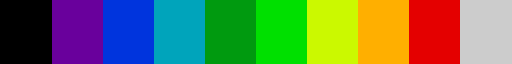

In [1]:
import zipfile
import json

from pathlib import Path
from pylab import cm
from torchvision import transforms
from tqdm.autonotebook import tqdm
from torch.utils.data import DataLoader

from layout_gnn.dataset.collate import default_data_collate
from layout_gnn.dataset.dataset import RICOSemanticAnnotationsDataset, ENRICOSemanticAnnotationsDataset
from layout_gnn.dataset.transforms.core import process_data, normalize_bboxes
from layout_gnn.dataset.transforms.image import RescaleImage
from layout_gnn.dataset.transforms.nx import add_networkx 
from layout_gnn.utils import *
from google.cloud import storage

ROOT_PATH = Path.cwd()
DATA_PATH = ROOT_PATH / '../data'
DATA_PATH.mkdir(parents=True, exist_ok=True)
BUCKET_ID = 'crowdstf-rico-uiuc-4540'

NUM_LABELS = 25
COLORS = cm.get_cmap('nipy_spectral', 10)
COLORS

## Download dataset

In [22]:
client = storage.Client()
bucket = client.get_bucket(BUCKET_ID)

blob = bucket.blob('rico_dataset_v0.1/semantic_annotations.zip')
blob.download_to_filename(DATA_PATH / 'semantic_annotations.zip')

In [24]:
with zipfile.ZipFile(DATA_PATH / 'semantic_annotations.zip', 'r') as zip_ref:
    zip_ref.extractall(DATA_PATH)

## Load files

In [2]:
transformations = transforms.Compose([
    process_data,
    normalize_bboxes,
    add_networkx,
    RescaleImage(500, 500)
])

In [3]:
rico_dataset = RICOSemanticAnnotationsDataset(root_dir=DATA_PATH, transform=transformations)

### Visualize one datapoint

In [4]:
datapoint = rico_dataset[0]
color_node_map, color_label_map = [], {}
for node, data in datapoint['graph'].nodes(data=True):
    if data['label'] not in color_label_map:
        color_label_map[data['label']] = COLORS(len(color_label_map))
    
    color_node_map.append(color_label_map[data['label']])

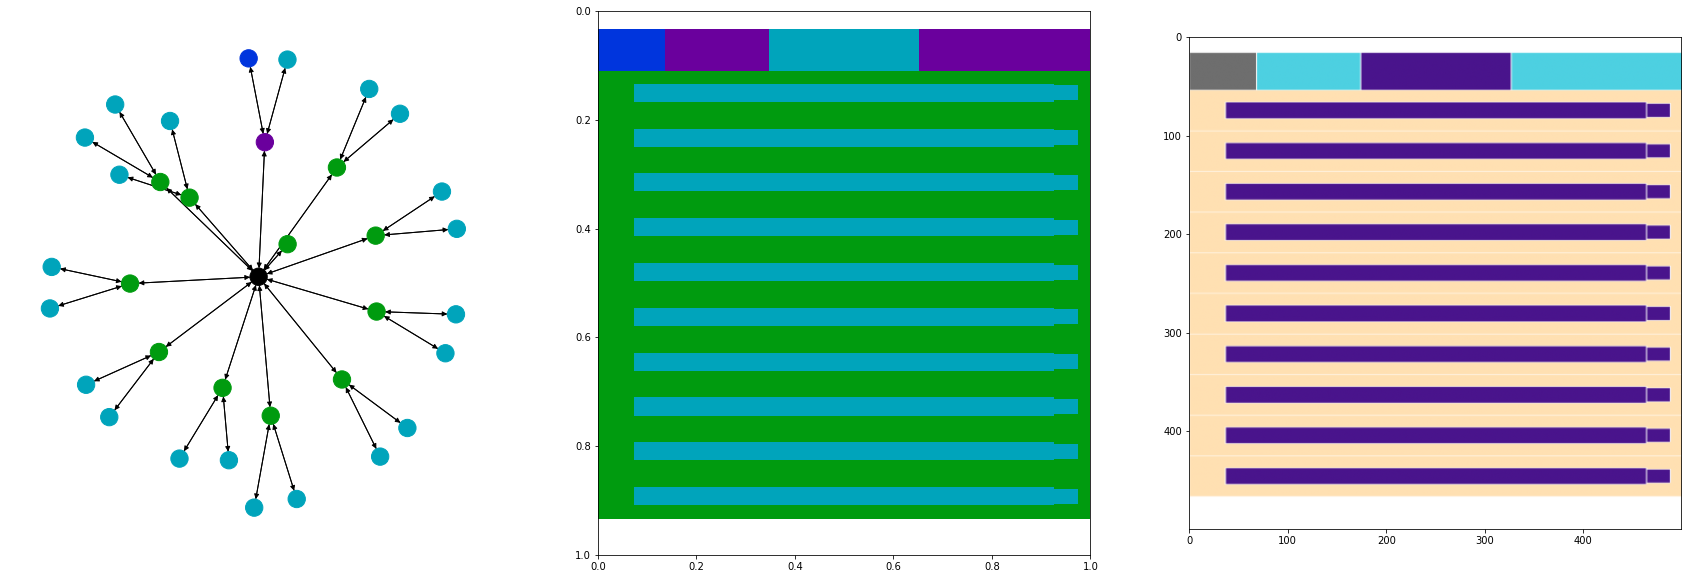

In [5]:
fig = plot_datapoint(datapoint, color_label_map, color_node_map)

## Dataset EDA

In [10]:
rico_only_data = RICOSemanticAnnotationsDataset(
    root_dir=DATA_PATH,
    transform=transforms.Compose([
        process_data,
        add_networkx,
    ])
)


In [11]:
rico_dataset_dataloader = DataLoader(rico_only_data, num_workers=8, collate_fn=default_data_collate)

In [12]:
node_labels = []
for datapoints in tqdm(rico_dataset_dataloader):
    node_labels += [node['label']  for datapoint in datapoints for _, node in datapoint['graph'].nodes(data=True)]

100%|██████████| 66261/66261 [50:46<00:00, 21.75it/s]  


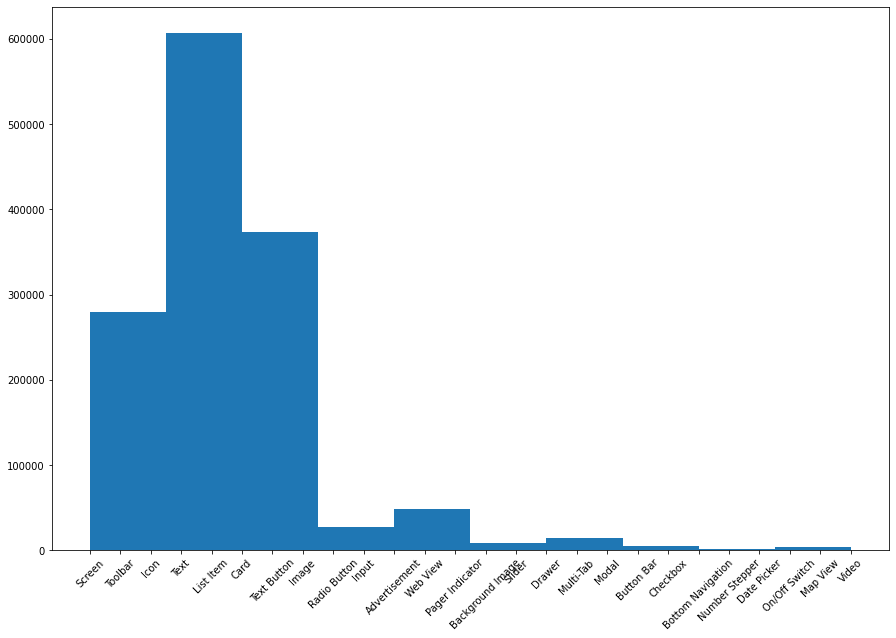

In [16]:
fig = plt.figure(figsize=(15, 10))
_ = plt.hist(node_labels)
_ = plt.xticks(rotation=45)

In [17]:
# Seems strange that we have more than 66K screens :thinking: 
# Probably we can't assume that element with empty class is always a screen.

26

## Load Enrico

In [2]:
dataset = ENRICOSemanticAnnotationsDataset()